# Scientific Data Analysis
Jasper Wink, 14616513 \
Dennis van der Werff, ...

# Imports

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import VAR


In [40]:
# Read data
cn = pd.read_csv("data/cryptonews.csv")
bp = pd.read_csv("data/btc.csv")

Group the data for each month. \
Determine the amount of articles for each month. \
Determine the mean opening bitcoin price for each month.

In [41]:
# Convert the date to the datetime format
cn['date'] = pd.to_datetime(cn['date'], format='%Y-%m-%d %H:%M:%S')
bp['date'] = pd.to_datetime(bp['Date'], format='%Y-%m-%d')

# Discard unnecairy date data, eg. hours, minutes etc
cn['weeks'] = cn['date'].dt.to_period('W')
bp['weeks'] = bp['date'].dt.to_period('W')

# Extract the polarity field out of the cn dataset
cn['sentiment'] = cn['sentiment'].apply(ast.literal_eval)
cn['polarity'] = cn['sentiment'].apply(lambda x: x['polarity'])

# Group data by the weeks
bp_weekly_open = bp.groupby('weeks')['Open'].mean().reset_index(name='open_mean')
bp_weekly_volume = bp.groupby('weeks')['Volume'].mean().reset_index(name='volume_mean')

cn_weekly_count = cn.groupby('weeks').size().reset_index(name='count')
cn_weekly_sentiment = cn.groupby('weeks')['polarity'].mean().reset_index(name='polarity_mean')


# Data visualisation

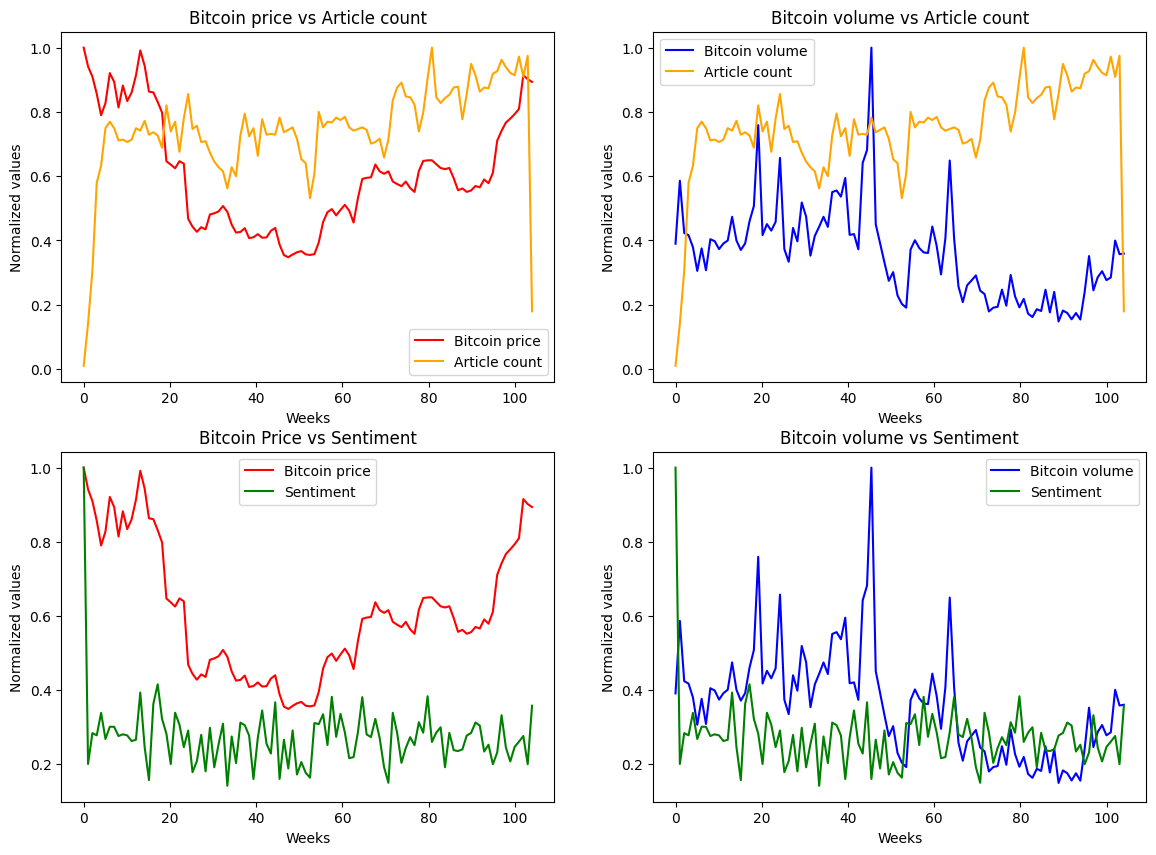

In [57]:
# Normalize the data
cn_count_list = list(cn_weekly_count['count'])
normalized_count = [count / max(cn_count_list) for count in cn_count_list]

bp_mean_list = list(bp_weekly_open['open_mean'])
normalized_price = [mean / max(bp_mean_list) for mean in bp_mean_list]

bp_volume_list = list(bp_weekly_volume['volume_mean'])
normalized_volume = [volume / max(bp_volume_list) for volume in bp_volume_list]

cn_sentiment_list = list(cn_weekly_sentiment['polarity_mean'])
normalized_sentiment = [sentiment / max(cn_sentiment_list) for sentiment in cn_sentiment_list]


x = np.linspace(0, len(normalized_count), len(normalized_count))
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Bitcoin Price vs Article Count
axes[0, 0].plot(x, normalized_price, label='Bitcoin price', color='red')
axes[0, 0].plot(x, normalized_count, label='Article count', color='orange')
axes[0, 0].set_title('Bitcoin price vs Article count')
axes[0, 0].set_xlabel('Weeks')
axes[0, 0].set_ylabel('Normalized values')
axes[0, 0].legend()

# Bitcoin Volume vs Article Count
axes[0, 1].plot(x, normalized_volume, label='Bitcoin volume', color='blue')
axes[0, 1].plot(x, normalized_count, label='Article count', color='orange')
axes[0, 1].set_title('Bitcoin volume vs Article count')
axes[0, 1].set_xlabel('Weeks')
axes[0, 1].set_ylabel('Normalized values')
axes[0, 1].legend()

# Bitcoin Price vs Sentiment
axes[1, 0].plot(x, normalized_price, label='Bitcoin price', color='red')
axes[1, 0].plot(x, normalized_sentiment, label='Sentiment', color='green')
axes[1, 0].set_title('Bitcoin Price vs Sentiment')
axes[1, 0].set_xlabel('Weeks')
axes[1, 0].set_ylabel('Normalized values')
axes[1, 0].legend()

# Bitcoin Volume vs Sentiment
axes[1, 1].plot(x, normalized_volume, label='Bitcoin volume', color='blue')
axes[1, 1].plot(x, normalized_sentiment, label='Sentiment', color='green')
axes[1, 1].set_title('Bitcoin volume vs Sentiment')
axes[1, 1].set_xlabel('Weeks')
axes[1, 1].set_ylabel('Normalized values')
axes[1, 1].legend()

plt.show()


# Spearman Correlation
To be able to detect whether there is correlation between the bitcoin price and the amount of news articles and the bitcoin price and the average news sentiment we will be using spearman correlation.

In [56]:
# https://en.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient
def spearman_correlation(rank1, rank2):
    n = len(rank1)

    sum_d_squared = sum([(rank1[i] - rank2[i])**2 for i in range(n)])
    correlation = 1 - ((6 * sum_d_squared) / (n * (n**2 - 1)))
    return correlation


# Calculate ranks
bp_open_rank = list(bp_weekly_open['open_mean'].diff().dropna().rank())
bp_volume_rank = list(bp_weekly_volume['volume_mean'].rank()[1:])
cn_count_rank = list(cn_weekly_count['count'].rank()[1:])
cn_sentiment_rank = list(cn_weekly_sentiment['polarity_mean'].rank()[1:])

pairs = [[bp_open_rank, cn_count_rank], [bp_volume_rank, cn_count_rank],
         [bp_open_rank, cn_sentiment_rank], [bp_volume_rank, cn_sentiment_rank]]

names = ['open price vs article count', 'volume vs article count',
         'open price vs sentiment', 'volume vs sentiment']

for i, pair in enumerate(pairs):
    correlation = spearman_correlation(pair[0], pair[1])
    print(f'{names[i]}')
    print(f'Spearman Correlation: {correlation:.3f}\n')


open price vs article count
Spearman Correlation: 0.165

volume vs article count
Spearman Correlation: -0.466

open price vs sentiment
Spearman Correlation: 0.201

volume vs sentiment
Spearman Correlation: 0.096



# Stationary test

Using the Augmented Dickey-Fuller (ADF) test to check if the current data is satationary. If the p-value scores lower than 0.05 we reject the $H_0$ and determine that the data is stationary.

In [59]:
ad_fuller_result_1 = adfuller(bp_weekly_open['open_mean'].diff().dropna())
print(f'p-value: {ad_fuller_result_1[1]} (Bitcoint price)')

ad_fuller_result_2 = adfuller(bp_weekly_volume['volume_mean'].diff().dropna())
print(f'p-value: {ad_fuller_result_2[1]} (Bitcoint volume)')

ad_fuller_result_3 = adfuller(cn_weekly_count['count'])
print(f'p-value: {ad_fuller_result_3[1]} (Article count)')

ad_fuller_result_4 = adfuller(cn_weekly_sentiment['polarity_mean'])
print(f'p-value: {ad_fuller_result_4[1]} (News sentiment)')


p-value: 4.4567176804253537e-13 (Bitcoint price)
p-value: 6.038046780346206e-13 (Bitcoint volume)
p-value: 4.5240581131031196e-05 (Article count)
p-value: 1.3517752025053774e-29 (News sentiment)


# Granger causality

To determine if one variable causes a change in another variable we are using Granger causality. If the p-value of a lag is lower than 0.05 we can determine that this lag influences the variable.

In [61]:
count_price_merge = pd.merge(cn_weekly_count, bp_weekly_open, on='weeks', how='inner')

# Test if article count causes the opening price
granger_1 = grangercausalitytests(count_price_merge[['count', 'open_mean']], 10)
print(granger_1)

# Test if opening price causes the article count
granger_2 = grangercausalitytests(count_price_merge[['open_mean', 'count']], 10)
print(granger_2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0511  , p=0.8216  , df_denom=100, df_num=1
ssr based chi2 test:   chi2=0.0526  , p=0.8186  , df=1
likelihood ratio test: chi2=0.0526  , p=0.8186  , df=1
parameter F test:         F=0.0511  , p=0.8216  , df_denom=100, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3786  , p=0.2568  , df_denom=97, df_num=2
ssr based chi2 test:   chi2=2.8993  , p=0.2346  , df=2
likelihood ratio test: chi2=2.8589  , p=0.2394  , df=2
parameter F test:         F=1.3786  , p=0.2568  , df_denom=97, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4691  , p=0.0667  , df_denom=94, df_num=3
ssr based chi2 test:   chi2=7.9589  , p=0.0469  , df=3
likelihood ratio test: chi2=7.6609  , p=0.0536  , df=3
parameter F test:         F=2.4691  , p=0.0667  , df_denom=94, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8718  , p=0.1221  , df